In [1]:
# This class tests whether tensorflow and autograd both calculate the hessian-vector-products identically.

# The rosenbrock function is not a least squares optimization problem. 
# Additionally, I have formulated the loss function in such a way that to find a minimum, we need to 
# calculate the hessian-vector product.

In [2]:
from autograd import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sopt.optimizers.autograd.lma import LMA as LMAag
from sopt.optimizers.tensorflow.lma import LMA as LMAtf

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def rosenbrock(x):
    x_reshaped = np.reshape(x, [2, -1])
    return np.sum(100*(x_reshaped[1] - x_reshaped[0]**2)**2 + (1 - x_reshaped[0])**2)

In [5]:
x_fn = lambda z: z
z_init = np.zeros(10)

In [6]:
# Autograd
lma_ag = LMAag(z_init, x_fn, rosenbrock, squared_loss=False, cg_tol=1e-5, max_cg_iter=20)

In [7]:
ag_losses = [rosenbrock(x_fn(z_init))]
for i in range(15):
    out = lma_ag.minimize()
    lossval = rosenbrock(x_fn(out))
    ag_losses.append(lossval)

Stopping iteration. Very low loss value: 9.182410219254432e-07


In [8]:
# Tensorflow
tf.reset_default_graph()
tf_var = tf.Variable(z_init, dtype='float32')
tf_x_fn = lambda x: tf.identity(x)
tf_x_fn_tensor = tf_x_fn(tf_var)

def tf_rosenbrock(x):
    x_reshaped = tf.reshape(x, [2, -1])
    return tf.reduce_sum(100*(x_reshaped[1] - x_reshaped[0]**2)**2 + (1 - x_reshaped[0])**2)

tf_rosenbrock_tensor = tf_rosenbrock(tf_x_fn_tensor)

lma_tf = LMAtf(tf_var, tf_x_fn, tf_rosenbrock, name='ros', min_cg_tol=1e-5, assert_tolerances=False)
minimizer = lma_tf.minimize()

session = tf.Session()
session.run(tf.global_variables_initializer())



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [9]:
tf_losses = [session.run(tf_rosenbrock_tensor)]
for i in range(15):
    session.run(minimizer)
    lossval = session.run(tf_rosenbrock_tensor)
    tf_losses.append(lossval)

In [10]:
session.run([lma_tf._iteration, lma_tf._mu])

[26, 0.0004]

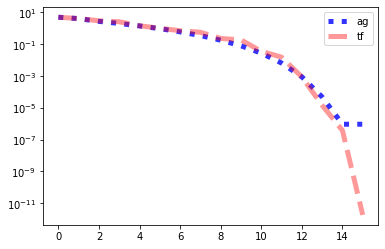

In [11]:
plt.plot(ag_losses, color='blue', ls=':', linewidth=5.0, alpha=0.8, label='ag')
plt.plot(tf_losses, color='red', ls='--', linewidth=5.0, alpha=0.4, label='tf')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [12]:
# Solution is all ones
session.run(lma_tf._input_var)

array([0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 , 0.9999998 ],
      dtype=float32)